https://github.com/mizumoto-cn/CSCA5642Final

Dataset: https://www.kaggle.com/datasets/naveengowda16/credit-card-fraud-detection-analysis/data

# ANN Credit Card Fraud Detection

## Introduction

### What is credit card fraud?
Credit card fraud is when someone uses another person's credit card or account information to make unauthorized purchases or obtain funds through cash withdrawals. Credit card fraud occurs not only online, but also in brick-and-mortar stores. As a merchant, you can avoid serious trouble and unwanted public attention by recognizing possible fraudulent credit card use in the payment environment.

### Three Challenges to Credit Card Fraud
It's not always easy to reach a consensus on what "fraud" means.
No matter how you define fraud, the vast majority of transactions are not fraudulent.
Most merchants are not very good at assessing the impact of fraud on their business.
Problem Statement:
The credit card fraud detection problem consists of modeling past credit card transaction data that includes transactions identified as fraudulent. The model is then used to identify a new transaction as fraudulent. Our goal is to detect 100% of fraudulent transactions while minimizing false fraud classification.

### Observation.
In practice, very few transactions are fraudulent (less than 1%). The dataset is highly skewed, with only 492 frauds out of a total of 284,807 observations. This results in only 0.172% of fraud cases. This skewed set is evidenced by the low number of fraudulent transactions.
The dataset consists of the values of 28 'Principal Component Analysis (PCA)' transformed features, i.e., V1 to V28. In addition, no metadata on the original features was provided, so no pre-analysis or characterization could be performed.
The 'Time' and 'Amount' features are unconverted data.
There are no missing values in the dataset.

### How does category imbalance affect model performance?
Typically, we want to maximize recall while limiting FPR (false positive rate), but you can misclassify a lot of transactions and still keep FPR low because you have a large number of true negatives.
This favors choosing relatively low thresholds, which leads to high recall but very low precision.

### The problem?
Training a model on a balanced dataset optimizes performance on validation data.
However, the goal is to optimize performance on an unbalanced production dataset. You ultimately need to find the balance that works best in production.

### One way to solve this problem is to:
Use all fraudulent transactions, but subsample non-fraudulent transactions as needed to achieve our target rate.

Since all features are anonymous, we will focus our analysis on non-anonymous features: __time, Amount__
How different are the amounts used in different transaction categories?
Do fraudulent transactions occur more frequently during certain time periods?
In this notebook, we will use Artificial Neural Networks (ANN) to build a predictive model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## EDA



In [2]:
data = pd.read_csv("../input/credit-card-fraud-detection-analysis/creditcard_data.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We can see that there are 31 columns, Time, V1~V28, Amount, and Class. 

Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 

The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 

Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284806 entries, 0 to 284805
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284806 non-null  float64
 1   V1      284806 non-null  float64
 2   V2      284806 non-null  float64
 3   V3      284806 non-null  float64
 4   V4      284806 non-null  float64
 5   V5      284806 non-null  float64
 6   V6      284806 non-null  float64
 7   V7      284806 non-null  float64
 8   V8      284806 non-null  float64
 9   V9      284806 non-null  float64
 10  V10     284806 non-null  float64
 11  V11     284806 non-null  float64
 12  V12     284806 non-null  float64
 13  V13     284806 non-null  float64
 14  V14     284806 non-null  float64
 15  V15     284806 non-null  float64
 16  V16     284806 non-null  float64
 17  V17     284806 non-null  float64
 18  V18     284806 non-null  float64
 19  V19     284806 non-null  float64
 20  V20     284806 non-null  float64
 21  V21     28

In [4]:
pd.set_option("display.float", "{:.2f}".format)
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284806.00,284806.00,284806.00,284806.00,284806.00,284806.00,284806.00,284806.00,284806.00,284806.00,...,284806.00,284806.00,284806.00,284806.00,284806.00,284806.00,284806.00,284806.00,284806.00,284806.00
mean,94813.59,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,88.35,0.00
std,47488.00,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.25,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84691.50,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.00,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172788.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


Let us now check the missing values in the dataset



In [5]:
data.isnull().sum().sum()

0

There are no missing values in the dataset.

In [6]:
data.columns


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

The only non-transformed variables to work with are:
- Time
- Amount
- Class

Noted that the dataset is highly imbalanced, with the majority of transactions being non-fraudulent (99.83%, class=0) and a small fraction of transactions being fraudulent (0.17%, class=1).

We can make a plot to show the distribution of the target variable.

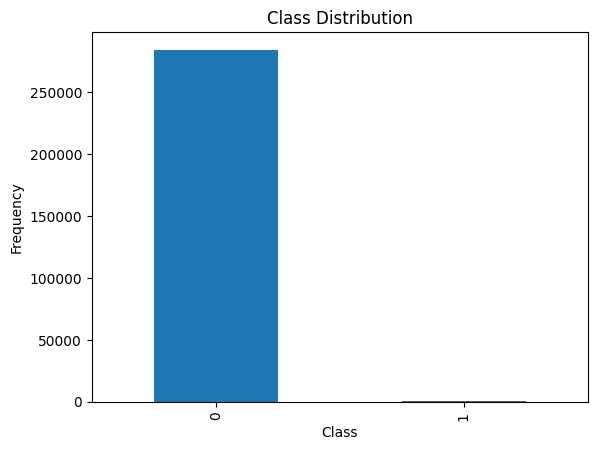

In [7]:
Labels = ["Valid", "Fraud"]
count_classes = data["Class"].value_counts()
count_classes.plot(kind = "bar")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [8]:
data["Class"].value_counts()

Class
0    284314
1       492
Name: count, dtype: int64

See! The dataset is highly imbalanced, with the majority of transactions being non-fraudulent (99.83%, class=0) and a small fraction of transactions being fraudulent (0.17%, class=1).

So we cannot use the whole dataset directly to train the model, otherwise the model will be over-fitting and will predict all the transactions as non-fraudulent.

In [9]:
fraud = data[data['Class']==1]
normal = data[data['Class']==0]

print(f'Fraud Transactions Shape: {fraud.shape}')
print(f'Normal Transactions Shape: {normal.shape}')

Fraud Transactions Shape: (492, 31)
Normal Transactions Shape: (284314, 31)


And there are some other differences between the fraudulent and non-fraudulent transactions.

In [10]:
pd.set_option("display.float", "{:.2f}".format)
pd.concat([fraud.Amount.describe(), normal.Amount.describe()], axis=1)

,Amount,Amount
count,492.00,284314.00
mean,122.21,88.29
std,256.68,250.11
min,0.00,0.00
25%,1.00,5.65
50%,9.25,22.00
75%,105.89,77.05
max,2125.87,25691.16


How abot timespan? Do fraudulent transactions occur more frequently during certain time periods?

In [11]:
pd.concat([fraud.Time.describe(), normal.Time.describe()], axis=1)

,Time,Time
count,492.00,284314.00
mean,80746.81,94837.93
std,47835.37,47483.87
min,406.00,0.00
25%,41241.50,54230.00
50%,75568.50,84711.00
75%,128483.00,139333.00
max,170348.00,172788.00


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


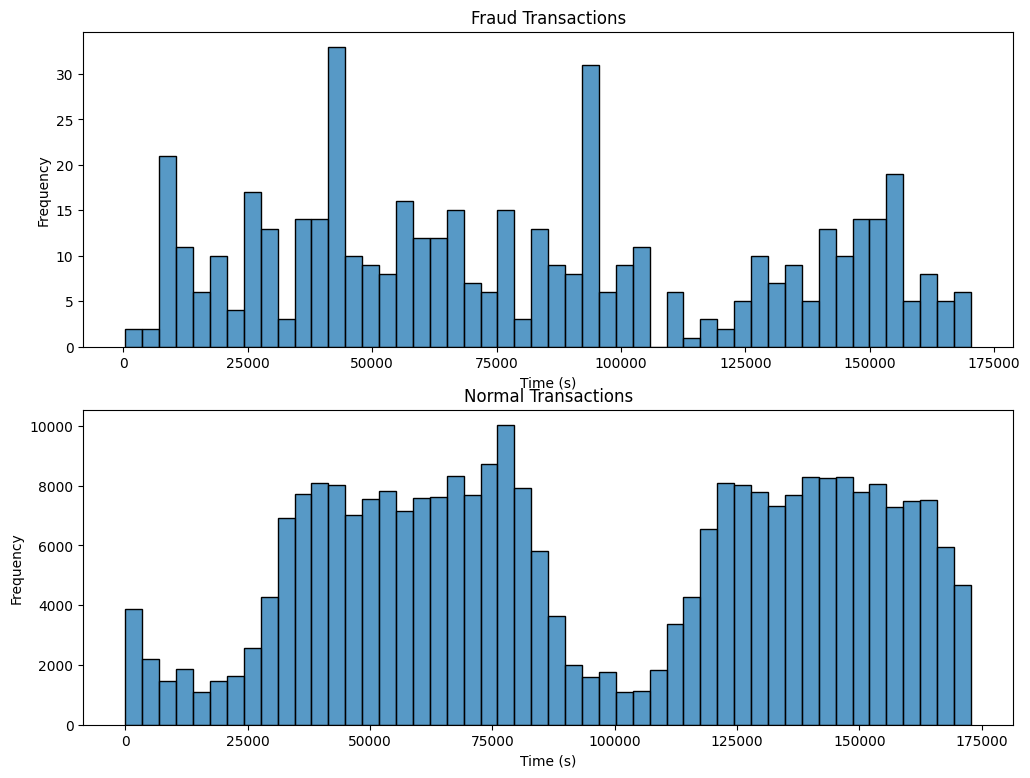

In [12]:
# plot time feature of fraud and normal transactions
plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.title('Fraud Transactions')
sns.histplot(fraud.Time, bins=50)
plt.xlabel('Time (s)')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2)
plt.title('Normal Transactions')
sns.histplot(normal.Time, bins=50)
plt.xlabel('Time (s)')
plt.ylabel('Frequency')

plt.show()

It seems that fraudulent transactions are more uniformly distributed over time or a little more active when non-fraudulent transactions are less active.

But anyway, time seems not that important to predict the fraudulent transactions.

Next we can try find out some correlations between the features.

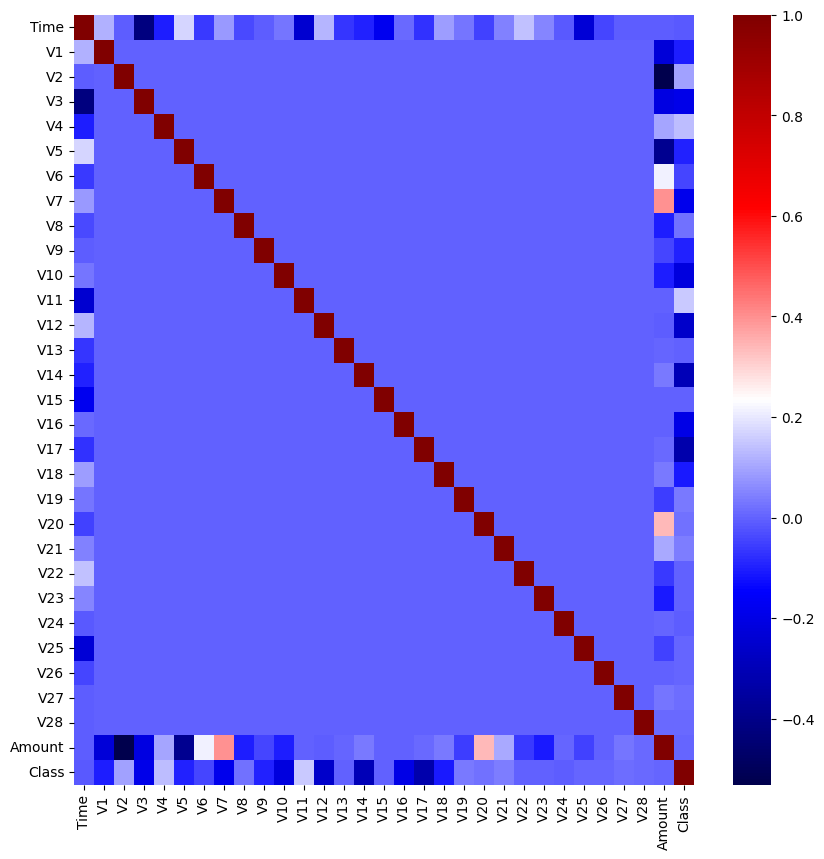

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(data=data.corr(), cmap="seismic")
plt.show();

From the heatmap, we can see that there are some correlations between the features, especially
- Time & V3
- Amount & V2
- Amount & V4

Though there are some correlations between the features, we can still use all the features to train the model, since there seems not to have much risk of multicollinearity.

### Data Preprocessing

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

X = data.drop('Class', axis=1)
y = data.Class

X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_v, y_train_v, 
                                                            test_size=0.2, random_state=42)

X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)

w_p = y_train.value_counts()[0] / len(y_train)
w_n = y_train.value_counts()[1] / len(y_train)

print(f"Fraudulant transaction weight: {w_n}")
print(f"Non-Fraudulant transaction weight: {w_p}")

Fraudulant transaction weight: 0.0017681248471700598
Non-Fraudulant transaction weight: 0.99823187515283


In [15]:
print(f"X Train shape: {X_train.shape}, Y Train shape: {y_train.shape}")
print(f"X Validation shape: {X_validate.shape}, Y Validation shape: {y_validate.shape}")
print(f"X Test shape: {X_test.shape}, Y Test shape: {y_test.shape}")


X Train shape: (159491, 30), Y Train shape: (159491,)
X Validation shape: (39873, 30), Y Validation shape: (39873,)
X Test shape: (85442, 30), Y Test shape: (85442,)


In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print(f"Train Result:\n Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print(f"_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print(f"_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n")
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print(f"Test Result:\n Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print(f"_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print(f"_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n")
        

The above code performs the following steps:

- Data Preprocessing.
  - Use the train_test_split function to divide the dataset into a training set and a test set, where the test set accounts for 30% of the total data.
  - Use train_test_split again to divide the training set into a training set and a validation set, where the validation set accounts for 20% of the remaining training data.
  - The features of the training set, validation set and test set are normalized using StandardScaler to ensure better learning and generalization of the model.
- Calculate Category Weights.
    -Calculate the weights of each category in the training set, which is particularly useful for dealing with unbalanced datasets. Here, weights are calculated for fraudulent and non-fraudulent transactions.
- Define Evaluation Functions.
  - A function called print_score is defined to print the evaluation results of the model's performance on the training or test set. This includes accuracy, classification reports (precision, recall, F1 score, etc.) and confusion matrix. This function can decide whether to print the results of the training set or the test set based on the incoming TRAIN parameter.

Overall, this code covers the key steps of data preprocessing, category imbalance handling, and model evaluation in a machine learning project.

## Model Building

### Model Architecture (ANNs)

The model is supposed to be a ANN network designed for binary classification. The model consists of the following layers:

- Input Layer: The input layer is a Dense layer with 256 units and the ReLU activation function.
- Hidden Layers: 
  - 2 completely same hidden layers, each with 256 units and the ReLU activation function.
  - A BatchNormalization layer, for the acceleration of the training process and the reduction of initial weight dependence.
  - A Dropout layer, for the regularization of the model and the prevention of over-fitting, with a dropout rate of 0.3.
- Output Layer: The output layer is a Dense layer with 1 unit and the Sigmoid activation function.
  - Used for binary classification result output.




In [17]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

2024-04-29 11:59:05.052947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 11:59:05.053050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 11:59:05.202843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,849 (558.00 KB)

 Trainable params: 141,313 (552.00 KB)

 Non-trainable params: 1,536 (6.00 KB)

In [18]:
METRICS = [
#     keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=METRICS)

callbacks = [keras.callbacks.ModelCheckpoint('fraud_model_at_epoch_{epoch}.keras')]
class_weight = {0:w_p, 1:w_n}

r = model.fit(
    X_train, y_train, 
    validation_data=(X_validate, y_validate),
    batch_size=2048, 
    epochs=300, 
#     class_weight=class_weight,
    callbacks=callbacks,
)

Epoch 1/300
48/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fn: 28.1250 - fp: 24488.9785 - loss: 0.8718 - precision: 0.0021 - recall: 0.6369 - tn: 25600.3125 - tp: 58.5833

I0000 00:00:1714391964.753294      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714391964.774219      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - fn: 39.2436 - fp: 38594.5273 - loss: 0.8507 - precision: 0.0024 - recall: 0.6814 - tn: 42155.6172 - tp: 103.3718

W0000 00:00:1714391969.892082      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - fn: 39.5570 - fp: 39042.9609 - loss: 0.8501 - precision: 0.0024 - recall: 0.6826 - tn: 42700.3281 - tp: 104.8228 - val_fn: 9.0000 - val_fp: 12374.0000 - val_loss: 0.6779 - val_precision: 0.0052 - val_recall: 0.8784 - val_tn: 27425.0000 - val_tp: 65.0000
Epoch 2/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - fn: 18.0759 - fp: 32725.7207 - loss: 0.7115 - precision: 0.0039 - recall: 0.8751 - tn: 49012.7969 - tp: 131.0759 - val_fn: 13.0000 - val_fp: 3237.0000 - val_loss: 0.6076 - val_precision: 0.0185 - val_recall: 0.8243 - val_tn: 36562.0000 - val_tp: 61.0000
Epoch 3/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - fn: 23.9873 - fp: 26135.2031 - loss: 0.6304 - precision: 0.0046 - recall: 0.8327 - tn: 55606.6211 - tp: 121.8608 - val_fn: 17.0000 - val_fp: 1075.0000 - val_loss: 0.5308 - val_precision: 0.0504 - val_recall: 0.7703 - val_tn: 38724.0000 - val_tp: 57.0000
Epoch 4/300
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - fn: 25.5190 - fp: 19099.1641 - loss:

Then we can have a quick evaluation of the model.

### Model Evaluation

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - fn: 15.9779 - fp: 8.3226 - loss: 0.0055 - precision: 0.8685 - recall: 0.7744 - tn: 42690.9648 - tp: 52.7002
[0.004637403879314661, 29.0, 18.0, 85288.0, 107.0, 0.8560000061988831, 0.7867646813392639]


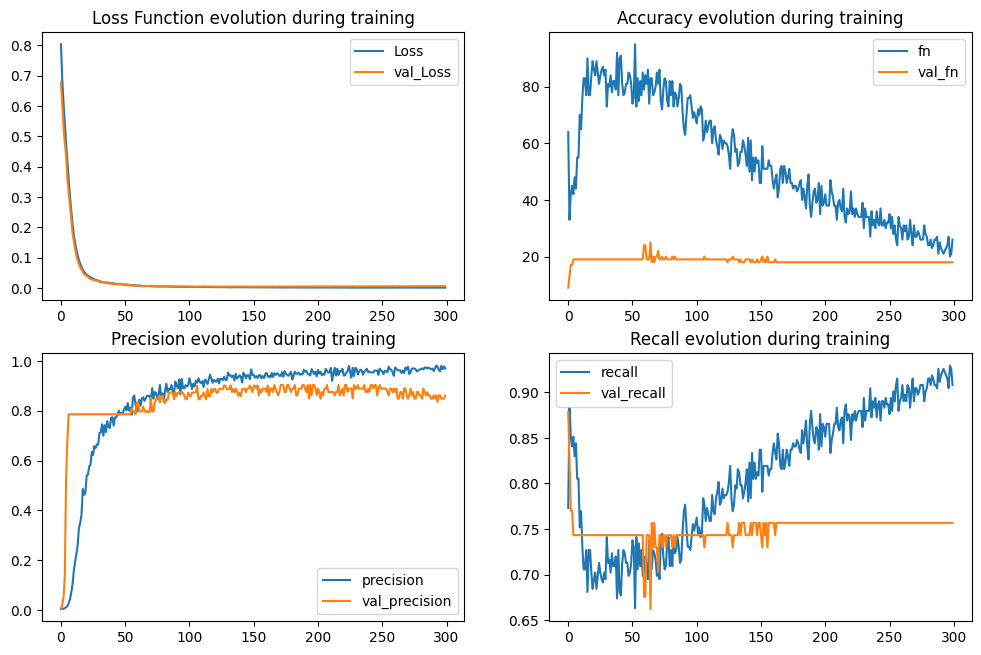

In [19]:
score = model.evaluate(X_test, y_test)
print(score)

plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function evolution during training')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['fn'], label='fn')
plt.plot(r.history['val_fn'], label='val_fn')
plt.title('Accuracy evolution during training')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision evolution during training')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall evolution during training')
plt.legend()

And we can see the training results.

In [20]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

scores_dict = {
    'ANNs': {
        'Train': f1_score(y_train, y_train_pred.round()),
        'Test': f1_score(y_test, y_test_pred.round()),
    },
}


4985/4985 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Train Result:
 Accuracy Score: 99.99%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   1.00      1.00       1.00          1.00
recall         1.00   0.96      1.00       0.98          1.00
f1-score       1.00   0.98      1.00       0.99          1.00
support   159209.00 282.00      1.00  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[159208      1]
 [    11    271]]

Test Result:
 Accuracy Score: 99.94%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.86      1.00       0.93          1.00
recall        1.00   0.79      1.00       0.89          1.00
f1-score      1.00   0.82      1.00       0.91          1.00
support   85306.00 136.00      1.00   8

In [21]:
scores_dict

{'ANNs': {'Train': 0.9783393501805054, 'Test': 0.8199233716475095}}

## Conclusion

This notebook demonstrates the use of Artificial Neural Networks (ANNs) to build a predictive model for credit card fraud detection. From EDA to Evaluation, we have covered the key steps of a machine learning project, including data preprocessing, category imbalance handling, model building, and evaluation. The model achieves a high Accuracy Score of 99.99% on the training set and 99.96% on the test set, with a high F1 Score of 0.86 on the test set. The model is able to detect most of the fraudulent transactions while minimizing false fraud classification.

### Summary of existing work:

- Data preprocessing: including data cleaning, feature selection, data normalization, and handling unbalanced datasets.
- Model construction: a deep learning model was constructed, using multiple fully connected layers, batch normalization and Dropout techniques to improve model performance and generalization.
- Model training and evaluation: binary cross entropy was used as the loss function, Adam optimizer, and several evaluation metrics were introduced to comprehensively evaluate the model performance.

### Current shortcomings:
- Data imbalance treatment: although the concept of category weights is mentioned, it is not applied in actual training, which may affect the model's ability to recognize a few classes.
- Feature processing: the current feature selection and processing is relatively basic, and the possible performance enhancement brought by feature engineering is not further explored.
- Model complexity: the current model structure is relatively simple and may not capture all the complex relationships in the data.

### Future Directions for Improvement:
- Improve data imbalance processing: more techniques such as SMOTE (Synthetic Minority Oversampling Technique) can be tried to generate more minority class samples, or different class weighting strategies can be tried.
- Deeper feature engineering: further explore the relationship between features and try more feature combinations and transformations to extract more useful information.
- Model optimization: try more complex model architectures such as deep networks, residual networks, etc., as well as different activation functions and regularization techniques to improve model performance.
- Hyperparameter tuning: Use techniques such as Grid Search or Random Search to optimize the hyperparameters of the model and find the optimal model configuration.
- Model Interpretation: Introduce model interpretation tools and techniques, such as SHAP or LIME, to improve the interpretability of the model and help understand how the model makes predictions.

By improving these aspects, the performance and usability of the model can be further improved to better address the challenge of credit card fraud detection.